In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import re
import requests
import os
tqdm.pandas()
%load_ext google.cloud.bigquery

## Vehicle Type & Geography variables

In [203]:
# Phase out this bit. 
lad_code='K02000001'
geography_name = 'United Kingdom'
bodyType = 'Cars'
geography_abbreviation = 'UK'

## Step 1: Pre-process data

### 1.1 Fuel Consumption Data

The Department for Business, Energy Security and Industrial Strategy (as was) publishes sub-national fuel consumption data, from which we can extract data for the UK. Unfortunately they publish one year on one tab of the document, meaning we need to write a little script to extract the data and put it in a better format. 

Input: 'sub-national-road-transport-fuel-consumption-statistics-2005-20**.ods' from inside the `data` folder, available at https://www.gov.uk/government/collections/road-transport-consumption-at-regional-and-local-level 

Output: a CSV file with cleaned up fuel consumption data, where each row is a year, so that we can see the trend over time. The csv `yearly_fuel_consumption.csv` is saved in the `data` folder. 

In [204]:
if not os.path.isfile('data/uk_yearly_fuel.csv'.format(geography_abbreviation.lower())):

    years = list(range(2005, 2021))
    years = [str(x) for x in years]

    fl = []

    for year in tqdm(years):
        df = pd.read_excel('data/sub-national-road-transport-fuel-consumption-statistics-2005-2020.ods', header=3, sheet_name=year)
        df = df[df['Local Authority Code'] == lad_code]
        df['year'] = int(year)
        fl.append(df)

    fc = pd.concat(fl)

    fc.set_index('year', inplace=True)

    fc.index = pd.to_datetime(fc.index, format='%Y')

    fc.to_csv('data/uk_yearly_fuel.csv'.format(lad_code))
else:
    fc = pd.read_csv('data/uk_yearly_fuel.csv'.format(geography_abbreviation.lower()), index_col=0)
    fc.index = pd.to_datetime(fc.index)

### 1.2 Vehicle Fleet Composition Data

We want to know how many cars are on the road in the UK. DfT publishes two tables which cover this, from their Vehicle Licensing Statistics data series (here: https://www.gov.uk/government/statistical-data-sets/vehicle-licensing-statistics-data-tables). 

The two tables are VEH0105 and VEH0142 covering the number of petrol, diesel and other fossil fuelled vehicles, and different kinds of low emissions vehicles respectively. Because these are in two different sheets, we need a script (below) that will clean them up and make them more usable. It's very slow, unfortunately. 

Inputs: 'veh0105.ods' and 'veh0142' from the `data` folder. They are saved into one CSV called `vehicle_parc.csv`



In [205]:
def ft_cleaner_dft(x):
    x = x.replace('Battery electric', 'Pure Electric')
    x = x.replace('Other fuels', 'Other').replace('Other fuel types', 'Other')
    x = x.replace('Plug-in hybrid electric (diesel)', 'Diesel')
    x = x.replace('Range extended electric', 'Pure Electric')
    x = x.replace('Plug-in hybrid electric (petrol)', 'Hybrid')
    x = x.replace('Hybrid electric (petrol)', 'Hybrid')
    x = x.replace('Hybrid electric (diesel)', 'Diesel')
    x = x.replace('Fuel cell electric', 'Pure Electric')
    x = x.replace('Gas', 'Other')
    return x

def ft_cleaner(x):
    x = x.replace('GAS BI-FUEL', 'Other').replace('GAS', 'Other').replace('GAS DIESEL', 'Other').replace('PETROL/GAS', 'Other').replace('LPG', 'Other').replace('STEAM', 'Other').replace('LNG', 'Other').replace('OTHER', 'Other').replace('CNG', 'Other')
    x = x.replace('FUEL CELLS', 'Other')
    x = x.replace('PETROL', 'Petrol').replace('Petrol/Other', 'Petrol')
    x = x.replace('HYBRID ELECTRIC (CLEAN)', 'Hybrid').replace('HYBRID ELECTRIC', 'Hybrid').replace('ELECTRIC DIESEL', 'Hybrid')
    x = x.replace('DIESEL', 'Diesel').replace('Other Diesel', 'Diesel')
    x = x.replace('ELECTRICITY', 'Pure Electric').replace('ELECTRIC', 'Pure Electric')
    return x

In [206]:
if not os.path.isfile('data/uk_vehicle_parc.csv'):

    # This deals with VEH0105. We're basically taking the ODS format document, and then dropping irrelevant bits of the table. Unfortunately as DfT like to change the way they format their spreadsheets, this will likely break in the future or need amendment to keep it working OK. 

    veh0105 = pd.read_excel('data/veh0105.ods', sheet_name='VEH0105', header=4)
    veh0105.drop(columns=['Units', 'ONS Geography [note 6]'], inplace=True)
    veh0105 = veh0105[veh0105.BodyType != 'Total']
    veh0105 = veh0105[veh0105['Fuel [note 2]'] != 'Total']
    veh0105 = veh0105[veh0105['Keepership [note 3]'] != 'Total']
    veh0105 = veh0105[veh0105['ONS Code [note 6]'] == lad_code]
    veh0105.drop(columns=['ONS Sort [note 6]', 'ONS Code [note 6]'], inplace=True)
    veh0105.rename(columns={'Fuel [note 2]': 'Fuel', 'Keepership [note 3]': 'Keepership'}, inplace=True)
    veh0105 = veh0105.melt(id_vars=['BodyType', 'Fuel', 'Keepership'])
    veh0105['value'] = veh0105.value.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    veh0105['variable'] = pd.PeriodIndex(veh0105['variable'].apply(lambda x: x.replace(' ', '-')), freq='Q').to_timestamp()
    veh0105['value'] = veh0105['value'].apply(lambda x: x*1000)
    
    # Now import VEH0142
    veh0142 = pd.read_excel('data/veh0142.ods', sheet_name='VEH0142', header=4)
    veh0142.drop(columns=['Units', 'ONS Geography [note 6]'], inplace=True)
    veh0142 = veh0142[veh0142['Fuel'] != 'Total']
    veh0142 = veh0142[veh0142['BodyType'] != 'Total']
    veh0142 = veh0142[veh0142['Keepership [note 3]'] != 'Total']
    veh0142 = veh0142[veh0142['ONS Code [note 6]'] == lad_code]
    veh0142.drop(columns=['ONS Sort [note 6]', 'ONS Code [note 6]'], inplace=True)
    veh0142.rename(columns={'Fuel [note 2]': 'Fuel', 'Keepership [note 3]': 'Keepership'}, inplace=True)
    veh0142 = veh0142.melt(id_vars=['Fuel', 'Keepership', 'BodyType'])
    veh0142['value'] = veh0142.value.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    veh0142['variable'] = pd.PeriodIndex(veh0142['variable'].apply(lambda x: x.replace(' ', '-')), freq='Q').to_timestamp()
    
    pc = pd.concat([veh0142, veh0105])
    pc['variable'] = pc.variable.apply(pd.to_datetime)
    pc = pc.groupby(['variable', 'BodyType', 'Fuel']).sum().reset_index(['BodyType', 'Fuel'])
    pc['Fuel'] = pc.Fuel.apply(ft_cleaner_dft)
    pc = pc.reset_index().groupby(['variable', 'BodyType', 'Fuel']).sum().reset_index(['BodyType', 'Fuel'])
    
    pc.to_csv('data/uk_vehicle_parc.csv')
    
else:
    pc = pd.read_csv('data/uk_vehicle_parc.csv', index_col=0)
    pc.index = pd.to_datetime(pc.index)

In [207]:
cars = pc[pc.BodyType == bodyType].pivot(columns='Fuel', values='value').resample('Y').last()

### 1.3 Average vehicle Milaege

We want to know how annual mileage is changing in UK. This was calculated using a query 'Annual Welsh Car Mileage by Fueltype', which is saved in BigQuery. That query essentially takes a selection of vehicles that have had an MOT in a Welsh postcode district, and then calculates its annual mileage, which is then allocated to a year (imperfectly). Lastly, we group them by a particular set of fueltypes (Petrol, Diesel and Electric, with hybrids grouped into Petrol) and the mean is calculated. 

A note on this. Why do we take the mean? We want to know things about the total demand for vehicle miles (perhaps) more than the behaviour of particular outliers. Knowing the total number of vehicles and the average mileage gives us a good indication of this. It may limit our ability to consider how targeting high miler vehicles might accelerate the transition, but there will be some possibility to consider a reduction in the average mileage driven by fossil fuel. Also, the MOT database does not give us a complete picture of the whole vehicle parc, since it misses young vehicles. So using it a bit like a survey, taking the mean, and using that in conjunction with the total number of vehicles, seems like it could be a sensible approach. 

In [208]:
mm = pd.read_csv('data/cars_average_mileage.csv')
mm['year'] = pd.to_datetime(mm.year, format='%Y')

In [209]:
mm.fuelType.unique()

array(['Petrol', 'Pure electric', 'Diesel', 'Hybrid', 'Other'],
      dtype=object)

In [210]:
mm = mm.set_index('year').pivot(columns='fuelType', values='annual_mileage').resample('Y').first()
mm = mm[mm.index>'2006-12-31']

In [211]:
mm.rename(columns={
    'Diesel': 'diesel_mileage',
    'Hybrid': 'hybrid_mileage',
    'Other': 'other_ft_mileage',
    'Petrol': 'petrol_mileage',
    'Pure electric': 'electric_mileage'
}, inplace=True)

### 1.4 Traffic Data

This gets GB data unless a valid region code is specified. LAD-level data is available from DfT, too, from a different endpoint. 

In [212]:
# r = requests.get('https://roadtraffic.dft.gov.uk/api/regions')
# ons_codes = []
# id_codes = []


# for x in r.json():
#     ons_codes.append(x['ons_code'])
#     id_codes.append(x['id'])
    
# region_dict = dict(zip(id_codes, ons_codes))

# try:
#     url = 'https://roadtraffic.dft.gov.uk/api/traffic/regions/vehicle-type?filter[region_id]={}'.format(region_dict[lad_code])
#     r = requests.get(url)
#     tra = pd.DataFrame(r.json()['data'])
#     tra['year'] = tra.year.apply(lambda x: pd.to_datetime(x, format='%Y'))

#     tra.set_index('year', inplace=True)
#     tra = tra.resample('Y').last()
#     tra = tra.drop(columns=['id', 'region_id', 'ons_code', 'total_link_length_km', 'total_link_length_miles'])
    
# except:
    
#     url = 'https://roadtraffic.dft.gov.uk/api/charts/traffic/annual/vehicle-type'
#     r = requests.get(url)
#     new_data = []
#     idx = []
#     names = []


#     data = r.json()

#     for d in data:
#         idx = [x[0] for x in d['data']]
#         names.append(d['id'])
#         new_data.append([x[1] for x in d['data']])

#     tra = pd.DataFrame(index=names, columns=idx, data=new_data).T
#     tra.index = pd.to_datetime(tra.index, format='%Y')
#     tra = tra.resample('Y').last()
#     tra = tra *1000000000

In [213]:
# r = requests.get('https://roadtraffic.dft.gov.uk/api/traffic/regions/vehicle-type?filter[region_id]=4')
# # r = requests.get(url)
# tra = pd.DataFrame(r.json()['data'])
# tra['year'] = tra.year.apply(lambda x: pd.to_datetime(x, format='%Y'))

# tra.set_index('year', inplace=True)
# tra = tra.resample('Y').last()
# tra = tra.drop(columns=['id', 'region_id', 'ons_code', 'total_link_length_km', 'total_link_length_miles'])

### 1.5 Vehicle Additions

We use VEH1153 to get newly registered vehicles, supplemented with our own data on Northern Irish registrations, since the DfT's UK-wide data only goes back to 2014, with older time periods only including GB-wide data. 

In [214]:
# nrg = pd.read_excel('data/veh1153.ods', sheet_name='VEH1153a_RoadUsing', header=4)
# nrg.columns = [re.sub('\[note \d\]', '', x) for x in nrg.columns]
# nrg.columns = [x.strip() for x in nrg.columns]

# ecc = nrg[
#     (nrg.Geography == 'Wales') &
#     (nrg['Date Interval'] == 'Monthly') &
#     (nrg.Units == "Thousands") &
#     (nrg.BodyType == "Cars")
# ]

# ecc['Date'] = ecc['Date'].apply(pd.to_datetime)

# # ecc = ecc.set_index('Date')

# ecc = ecc.drop(columns=['Total', 'Plug-in', 'Zero emission'])


# ecc = ecc.melt(id_vars=['Date', 'Geography', 'Date Interval', 'Units', 'BodyType'], value_vars=ecc.columns[5:]).rename(columns={'variable': 'fuelType'})

# ecc['fuelType'] = ecc.fuelType.apply(ft_cleaner_dft)
# ecc = ecc.groupby(['Date', 'fuelType']).sum().reset_index(['fuelType']).pivot(columns='fuelType').resample('Y').sum()
# ecc.columns = [x[1] for x in ecc.columns]
# ecc = 1000*ecc

# ecc.to_csv('data/new_registrations.csv')

In [215]:
if not os.path.isfile('data/new_registrations.csv'):

    nrg = pd.read_excel('data/veh1153.ods', sheet_name='VEH1153a_RoadUsing', header=4)
    nrg.columns = [re.sub('\[note \d\]', '', x) for x in nrg.columns]
    nrg.columns = [x.strip() for x in nrg.columns]
    
    nrg.to_csv('data/new_registrations.csv')
else:
    nrg = pd.read_csv('data/new_registrations.csv', index_col=0)

if geography_name == 'United Kingdom':
    geography_name_adj ='Great Britain'
else:
    geography_name_adj = geography_name

ecc = nrg[
    (nrg.Geography == geography_name_adj) &
    (nrg['Date Interval'] == 'Monthly') &
    (nrg.Units == "Thousands") &
    (nrg.BodyType == bodyType)
]

ecc['Date'] = ecc['Date'].apply(pd.to_datetime)

# ecc = ecc.set_index('Date')

ecc = ecc.drop(columns=['Total', 'Plug-in', 'Zero emission'])


ecc = ecc.melt(id_vars=['Date', 'Geography', 'Date Interval', 'Units', 'BodyType'], value_vars=ecc.columns[5:]).rename(columns={'variable': 'fuelType'})

ecc['fuelType'] = ecc.fuelType.apply(ft_cleaner_dft)
ecc = ecc.groupby(['Date', 'fuelType']).sum().reset_index(['fuelType']).pivot(columns='fuelType').resample('Y').sum()
ecc.columns = [x[1] for x in ecc.columns]
ecc = 1000*ecc

/Users/ben/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [216]:
# %%bigquery ni --project rugged-baton-283921
# SELECT monthOfFirstRegistration, fuelType, COUNT(*) as total
# FROM VES_dataset.VRN_UK
# WHERE typeApproval = 'N1'
# AND region='NI'
# AND fuelType IS NOT NULL
# AND monthOfFirstRegistration > '2000-12-31'
# AND monthOfFirstRegistration < '2022-12-31'
# GROUP BY monthOfFirstRegistration, fuelType

In [217]:
# Since we miss out Northern Ireland registrations, we pull in data on new car registrations from our own database to supplement the DfT statistics. 
ni = pd.read_csv('data/ni_new_cars.csv')

In [218]:
ni['fuelType'] = ni.fuelType.apply(ft_cleaner)
niw = ni.groupby(['monthOfFirstRegistration', 'fuelType']).sum().reset_index('fuelType').pivot(columns='fuelType', values='total')
niw.index = pd.to_datetime(niw.index, utc=None)
niw.index = niw.index.tz_localize(None)
niw = niw.resample('Y').last()
ecc = (ecc + niw)

<AxesSubplot:xlabel='Date'>

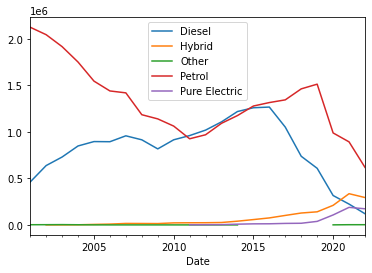

In [219]:
ecc.plot()

### 1.6 UK emissions

This is really what we are trying to estimate. The National Atmospheric Emissions Inventory tots up total territorial emissions, and publishes them. 

In [220]:
em = pd.read_excel('data/2209201114_DA_GHGI_1990-2020_Final_v4.1_AR4_AR5.xlsm', sheet_name='{} By Source_AR5'.format(geography_abbreviation), header=16, usecols='B:AC')
em['NCFormat'] = em.NCFormat.fillna(method='ffill')
em = em.melt(id_vars=['NCFormat', 'IPCC_name'])
em = em[em.variable != 'BaseYear']
em['variable']=em['variable'].apply(pd.to_datetime)
emt = em[em.NCFormat == 'Transport']
emt = emt.pivot(index='variable', columns='IPCC_name', values='value')
# emt.T.sort_values('2019-01-01', ascending=False)[['2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01']]

# emt.to_csv('outputs/transport_subsectors.csv')

In [221]:
emt.columns.tolist()

['1A3a_Domestic_aviation',
 '1A3bi_Cars',
 '1A3bii_Light_duty_trucks',
 '1A3biii_Heavy_duty_trucks_and_buses',
 '1A3biv_Motorcycles',
 '1A3bv_Other_road_transport',
 '1A3c_Railways',
 '1A3d_Domestic_navigation',
 '1A3eii_Other_Transportation',
 '1A4ai_Commercial/Institutional',
 '1A4ciii_Fishing',
 '1A5b_Other:Mobile',
 '2D1_Lubricant_Use',
 '2D3_Non-energy_products_from_fuels_and_solvent_use:Other']

# Part 2: Modelling and Estimating: Cars

The drivers of emissions are many and become quickly complicated. We'll start with the number of vehicles, annual mileage, fuel consumption, calculate fuel economy, and then create a simple way of plugging in fleet, mileage, and consumption numbers to get an emissions estimate. 

We'll load all these inputs into one dataframe, `df`. 

### 2.1 Car Parc & Miles Driven

In [332]:
# Create a DataFrame to hold our data

df = cars.merge(mm, how='left', left_index=True, right_index=True)
df = df[df.index > '2013-12-31']

In [333]:
# calculate total VMT by fuel type

df['diesel_vmt'] = df.apply(lambda row: row['Diesel'] * row['diesel_mileage'], axis=1)
df['petrol_vmt'] = df.apply(lambda row: row['Petrol'] * row['petrol_mileage'], axis=1)
df['electric_vmt'] = df.apply(lambda row: row['Pure Electric'] * row['electric_mileage'], axis=1)
df['hybrid_vmt'] = df.apply(lambda row: row['Hybrid'] * row['hybrid_mileage'], axis=1)

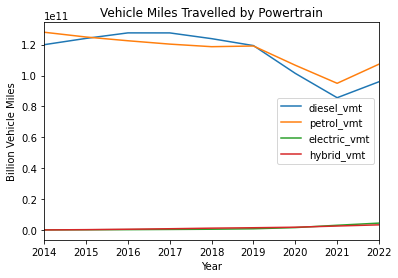

In [334]:
fig, ax = plt.subplots()

df[['diesel_vmt', 'petrol_vmt', 'electric_vmt', 'hybrid_vmt']].plot(ax=ax)
ax.set_title('Vehicle Miles Travelled by Powertrain')
ax.set_ylabel('Billion Vehicle Miles')
ax.set_xlabel('Year')

plt.show()

### 2.2 Adding in fuel consumption

In [335]:
# fc[['Diesel cars total', 'Petrol cars total']].rename(columns={
#     'Diesel cars total': 'car_diesel_consumption',
#     'Petrol cars total': 'car_petrol_consumption'
# }).resample('Y').last()

In [336]:
df = df.merge(fc[['Diesel cars total', 'Petrol cars total']].rename(columns={
    'Diesel cars total': 'car_diesel_consumption',
    'Petrol cars total': 'car_petrol_consumption'
}).resample('Y').last(),
        how='left',
        left_index=True,
        right_index=True)

In [358]:
# Calculate the amount of petrol that's consumed by pure petrol cars and hybrid cars. 
# On average, hybrids have 0.7 times the WLTP co2/km rating of petrol cars, so we'll use that as a very rough way of working out their fuel consumption
df['pure_petrol_share'] = df.apply(lambda row: row['petrol_vmt'] / (row['hybrid_vmt']*.7 + row['petrol_vmt']), axis=1)
df['hybrid_petrol_share'] = df.pure_petrol_share.apply(lambda x: 1-x)

In [359]:
df

,Diesel,Hybrid,Other,Petrol,Pure Electric,diesel_mileage,hybrid_mileage,other_ft_mileage,petrol_mileage,electric_mileage,...,pure_petrol_share,hybrid_petrol_share,petrol_car_petrol_consumption,hybrid_car_petrol_consumption,car_diesel_consumption_gallons,petrol_car_petrol_consumption_gallons,hybrid_car_petrol_consumption_gallons,petrol_economy,diesel_economy,hybrid_economy
variable,,,,,,,,,,,,,,,,,,,,,
2014-12-31,10968863.0,7232.0,246560.0,18739719.0,14328.0,10936.202744,10562.156377,10736.490969,6830.794536,6132.168427,...,0.999582,0.000418,13764.833246,8.213867,2.578579e+09,3.520740e+09,2.100926e+06,36.358027,46.520861,36.358027
2015-12-31,11651974.0,22988.0,308603.0,18574731.0,24451.0,10644.794975,10716.697489,10484.035654,6725.032887,6928.237950,...,0.998621,0.001379,13515.429120,26.654777,2.685415e+09,3.456948e+09,6.817703e+06,36.134669,46.187605,36.134669
2016-12-31,12296229.0,47909.0,386247.0,18492246.0,34488.0,10376.604466,10857.634603,10127.260827,6624.450468,7308.252598,...,0.997036,0.002964,13427.594093,57.017873,2.774299e+09,3.434482e+09,1.458391e+07,35.667961,45.991118,35.667961
2017-12-31,12615832.0,76282.0,490230.0,18423529.0,48907.0,10112.599653,10998.586613,9936.503505,6531.131889,7795.994137,...,0.995143,0.004857,13312.833468,92.825687,2.860521e+09,3.405129e+09,2.374276e+07,35.336843,44.599864,35.336843
2018-12-31,12662139.0,112966.0,619006.0,18568990.0,64881.0,9781.636033,10790.694828,9935.565102,6390.194843,8108.767237,...,0.992860,0.007140,13358.369227,137.229734,2.868091e+09,3.416776e+09,3.510033e+07,34.728491,43.184275,34.728491
2019-12-31,12567953.0,140534.0,778526.0,18894394.0,99473.0,9498.001392,10561.817871,10344.429713,6303.511363,8139.812848,...,0.991352,0.008648,13550.467315,168.872467,2.901744e+09,3.465910e+09,4.319385e+07,34.363564,41.137484,34.363564
2020-12-31,12255205.0,195529.0,1084319.0,18792569.0,201678.0,8273.260261,9350.317254,9315.795845,5675.050270,7840.222633,...,0.988142,0.011858,10399.187812,178.271156,2.139864e+09,2.659882e+09,4.559782e+07,40.095295,47.381756,40.095295
2021-12-31,11884303.0,296492.0,1630489.0,18723197.0,384077.0,7205.456602,8754.267393,8157.842332,5072.091349,8039.995988,...,0.981227,0.018773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31,11698381.0,344658.0,1969425.0,18814210.0,496082.0,8203.917407,9744.769186,9691.168302,5705.614549,9033.500161,...,0.978568,0.021432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [360]:
df['petrol_car_petrol_consumption'] = df.apply(lambda row: row['car_petrol_consumption'] * row['pure_petrol_share'], axis=1)
df['hybrid_car_petrol_consumption'] = df.apply(lambda row: row['car_petrol_consumption'] * row['hybrid_petrol_share'], axis=1)

Petrol and diesel consumption are currently in kilotonnes of oil equivalent. Let's do some processing to make them into something a bit nicer - gallons. 

We're going to multiply petrol and diesel consumption by 1000 to get tonnes of oil equivalent. Then to get to something a bit nicer, we'll use conversion factors from Eurostat (https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:Tonnes_of_oil_equivalent_(toe)) to get cubic metres, then from that we can convert them to gallons and calculate MPG. 



In [372]:
df['car_diesel_consumption_gallons'] = df.car_diesel_consumption.apply(lambda x: ((1000*x)/.98) * 219.969)

# NB that petrol has a different conversion factor. Tonnes of oil equivalent is essentially the energy content of the fuel, and diesel is more energy-dense. 
df['car_petrol_consumption_gallons'] = df.car_petrol_consumption.apply(lambda x: ((1000*x)/.86) * 219.969)
df['petrol_car_petrol_consumption_gallons'] = df.petrol_car_petrol_consumption.apply(lambda x: ((1000*x)/.86) * 219.969)
df['hybrid_car_petrol_consumption_gallons'] = df.hybrid_car_petrol_consumption.apply(lambda x: ((1000*x)/.86) * 219.969)


In [373]:
# df['hybrid_petrol_consumption_gallons'] = df.car_petrol_consumption_gallons.apply(lambda x: x*hybrid_fuel_factor)
# df['petrol_petrol_consumption_gallons'] = df.apply(lambda row: row['car_petrol_consumption_gallons'] - row['hybrid_petrol_consumption_gallons'], axis=1)

Now calculate fuel economy. 

In [374]:
df['pure_petrol_economy'] = df.apply(lambda row: row['petrol_vmt'] / row['petrol_car_petrol_consumption_gallons'] , axis=1)
df['diesel_economy'] = df.apply(lambda row: row['diesel_vmt'] / row['car_diesel_consumption_gallons'], axis=1)
df['hybrid_economy'] = df.apply(lambda row: row['hybrid_vmt'] / row['hybrid_car_petrol_consumption_gallons'] , axis=1)
df['petrol_economy'] = df.apply(lambda row: (row['hybrid_vmt'] + row['petrol_vmt']) / row['car_petrol_consumption_gallons'] , axis=1)

<AxesSubplot:xlabel='variable'>

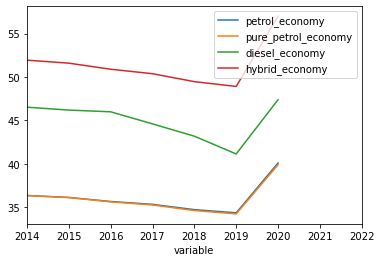

In [376]:
# fig, ax = plt.subplots(figsize=(12, 8))

df[['petrol_economy', 'pure_petrol_economy', 'diesel_economy', 'hybrid_economy']].plot()
# ax.set_title('Calculated Car Fuel Economy')
# ax.set_ylabel('Miles Per Gallon')
# ax.set_xlabel('Year')

# # ax.text(x=50, y=40, s='Large increase in\nfuel economy could \nbe due to less traffic \nduring lockdowns.')

# plt.show()

### 2.3 Calculate Emissions from Fuel Consumption

The first step here is to convert toe diesel and petrol consumption to an estimation of CO2e, using a conversion factor available from the government. This is the UK government's preferred emission factor for businesses and government departments. They are available here: https://www.gov.uk/government/publications/greenhouse-gas-reporting-conversion-factors-2022

To make this calculations, we multiply fuel consumption by 1000 to get the toe, then we convert the toe to kwh, then we convert the kwh to kgCO2e using a conversion factor from the spreadsheet above. 

The conversion factors used are:
* Petrol - 'Petrol average biofuel blend' - kWh (Gross CV) - .22719
* Diesel - 'Diesel average biofuel blend' - kWh (Gross CV) - .24115

In [377]:
# It seems the govt put out different factors every year. Not sure why this would change. 
# # Conversion factors from 2021
# df['diesel_emissions'] = df.car_diesel_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.23686)
# df['petrol_emissions'] = df.car_petrol_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.22980)

# # 2020 factors
# df['diesel_emissions'] = df.car_diesel_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.24057)
# df['petrol_emissions'] = df.car_petrol_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.2292)

# 2022 factors
df['diesel_emissions'] = df.car_diesel_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.24115)
df['petrol_emissions'] = df.car_petrol_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.22719)

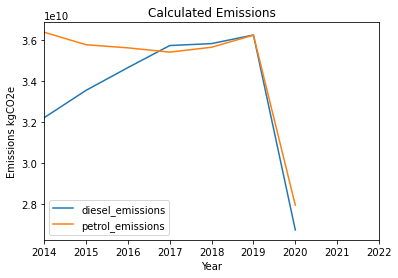

In [378]:
fig, ax = plt.subplots()

df[[
    'diesel_emissions', 
    'petrol_emissions', 
#     'diesel_emissions_2021', 
#     'petrol_emissions_2021'
]].plot(ax=ax)

ax.set_title('Calculated Emissions')
ax.set_ylabel('Emissions kgCO2e')
ax.set_xlabel('Year')

# plt.savefig('plots/')
plt.show()

### 2.4 Comparison with Official NAEI Emissions

In [379]:
df['total_kgCO2e_calc'] = df.apply(lambda row: row['diesel_emissions'] + row['petrol_emissions'], axis=1)
# df['total_kgCO2e_calc_2021'] = df.apply(lambda row: row['diesel_emissions_2021'] + row['petrol_emissions_2021'], axis=1)

In [382]:
df = df.merge(emt.resample('Y').last()[['1A3bi_Cars']]*1000000, how='left', left_index=True, right_index=True)

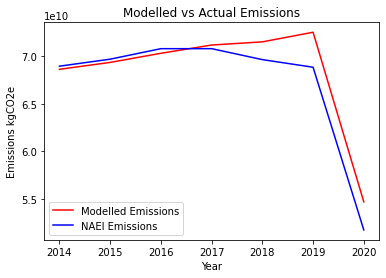

In [383]:
fig, ax = plt.subplots()
ax.plot(df.resample('YS').first().total_kgCO2e_calc, c='r', label='Modelled Emissions')
# ax.plot(df.resample('YS').first().total_kgCO2e_calc_2021, c='g', label='Modelled Emissions_2021')
ax.plot(df.resample('YS').first()['1A3bi_Cars'], c='b', label='NAEI Emissions')
# NB: resample above is just so that on the plot it displays emissions in that year directly above that year. So just for display purposes. 

ax.legend()

ax.set_ylabel('Emissions kgCO2e')
ax.set_xlabel('Year')
ax.set_title('Modelled vs Actual Emissions')
# plt.savefig('plots/accuracy_calc.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')
plt.show()

In [384]:
df['error'] = df['total_kgCO2e_calc'] / df['1A3bi_Cars']

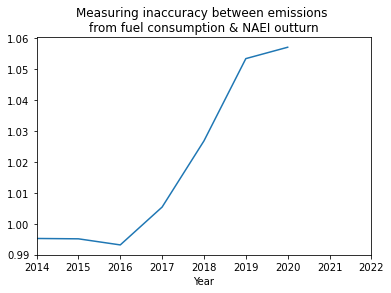

In [385]:
fig, ax = plt.subplots()

df.error.plot(ax=ax)
ax.set_title('Measuring inaccuracy between emissions \nfrom fuel consumption & NAEI outturn')
ax.set_xlabel('Year')
# plt.savefig('plots/accuracy_ratio.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')
plt.show()

It looks like we are usually within a 5 percentage point margin of error. That's probably tolerable. 

## Part 3: Scenario-ing

In this section, I am going to create some new scenarios and forecast what it might look like. 

Our forecast will be built into dataframe `dfp`

### 3.1 Scenario A: Car market growing according to trend, growth in line with ZEV mandate. 

Fleet changes will come about as:
* Retirements among petrol and diesel cars track new registrations a number of years previously (see above - 15 to 20 years). 
* Overall sales of vehicles stay at their current 10-year average, of around 85,000 cars. 
* Non-zev sales divide roughly 15:1 between petrol and diesel
* Sales of new petro and diesel cars decline as electric cars grow. 
* Petrol and Diesel mileage return to the average of the 5 years before the pandemic. 
* Petrol and Diesel fuel economy remains roughly static at pre-pandemic levels. 


In [478]:
# How many ICE sales should we allocate to diesel registrations? This just takes the last year's diesel share of ICE sales, i.e. 11%
diesel_share_of_ice = ecc[['Diesel', 'Petrol']].div(ecc[['Diesel', 'Petrol']].sum(axis=1), axis=0).iloc[-1].Diesel

In [479]:
# Vehicle retirements
ret = ecc.copy()
# Retirements happen automatically after X years
car_lifespan = 20
ret.index = ecc.index+pd.DateOffset(years=car_lifespan)
ret = ret.fillna(0)
# ret.to_csv('data/retirements.csv')

In [480]:
start = '2023-12-31'
end = '2050-12-31'

new_index = pd.date_range(start=start, end=end, freq='Y')
dfp = pd.DataFrame(index=new_index)
years = dfp.index

# Overal market size
total_annual_sales = []
sales = ecc.sum(axis=1).iloc[-5:].mean()
sales = 1800000
# sales = ecc.sum(axis=1).mean()

# By chosing all but the last 3 years, we're taking pre-pandemic growth
growth = 1 #+ ecc.sum(axis=1).iloc[12:-5].pct_change().mean()

for year in years:
    sales *= growth
    total_annual_sales.append(sales)

zev_trajectory = []

# i.e. ZEVs continue to constitute 8% of registrations from here on
# zev_mandate = [.08 for x in years]

# `zev_mandate` is the trajectory set out by DfT except for the first year (2023) which has no percentage target. 
zev_mandate = [.15, .22, .28, .33, .38, .52, .66, .80, .84, .88, .92, .96, 1]
for i, e in enumerate(years):
    try:
        zev_trajectory.append(zev_mandate[i])
    except:
        zev_trajectory.append(1)

new_electric = []
for i, e in enumerate(years):
    new_electric.append(zev_trajectory[i] * total_annual_sales[i])

# # Hybrid trajectory
# # hybrid_traj = [.25, .26, .27, .28, .29, .30, .66, .80, .84, .88, .92, .96, 1]
# new_hybrid = []
# for i, e in enumerate(years):
#     new_hybrid

total_ice_sales = []
for i, e in enumerate(years):
    total_ice_sales.append(total_annual_sales[i] - new_electric[i])


new_diesel = []
for i, e in enumerate(years):
    new_diesel.append(total_ice_sales[i] * diesel_share_of_ice)

new_petrol = []
for i, e in enumerate(years):
    new_petrol.append(total_ice_sales[i] - new_diesel[i])

dfp['new_diesel'] = new_diesel
dfp['new_petrol'] = new_petrol
dfp['new_electric'] = new_electric

In [481]:
diesel_parc = []
petrol_parc = []
electric_parc = []

# Our starting values, which will be changed by the new registration statistics. 
diesel = cars.Diesel.iloc[-1]
petrol = cars.Petrol.iloc[-1]
electric = cars['Pure Electric'].iloc[-1]

# _rets means a list of the number of cars that get retired each year, from that fueltype. 
# This is a bit complex. We take the number of retired cars as being the number registered X many years ago, where X is our estimate as to how long a typical car will live. 
# We take historic car registration statistics to calculate this. But there is an issue if we say that cars are going to live for 30 years, i.e. longer than our dataframe of new registrations. 
# We solve that issue by adding in Y number of years where 0 retirements happen, where Y is set at the number of years between the registrations. 
diesel_rets = [0 for x in list(range(round((ret.index.min() - pd.to_datetime(start)).days/365)))] + ret[ret.index >= start].Diesel.tolist() + new_diesel
petrol_rets = [0 for x in list(range(round((ret.index.min() - pd.to_datetime(start)).days/365)))] + ret[ret.index >= start].Petrol.tolist() + new_petrol
electric_rets = [0 for x in list(range(round((ret.index.min() - pd.to_datetime(start)).days/365)))] + ret[ret.index >= start]['Pure Electric'].tolist() + new_electric

# Adjust the retirement rates for previously registered diesels
# What is happening here is we are taking the sum of (the vehicles already in the parc, and the vehicles that we're projecting will be added to the parc),
# then we are finding the difference between all the vehicles the model will remove from the parc. 
# i.e. We are fixing the problem of the model adding/removing too many vehicles
# That difference needs to be accounted for. That is done so very simplistically (and controversially). If there is a 10% difference, then the retirements are all uplifted by 10%. 
left_over_diesels = (cars.Diesel.iloc[-1] + sum(new_diesel)) - sum(ret[ret.index >= start].Diesel.tolist() + new_diesel)
diesel_retirement_factor = (left_over_diesels + sum(ret[ret.index >= start].Diesel.tolist() + new_diesel)) / sum(ret[ret.index >= start].Diesel.tolist() + new_diesel)
diesel_rets = [diesel_retirement_factor*x for x in diesel_rets]

left_over_petrols = (cars.Petrol.iloc[-1] + sum(new_petrol)) - sum(ret[ret.index >= start].Petrol.tolist() + new_petrol)
petrol_retirement_factor = (left_over_petrols + sum(ret[ret.index >= start].Petrol.tolist() + new_petrol)) / sum(ret[ret.index >= start].Petrol.tolist() + new_petrol)
petrol_rets = [petrol_retirement_factor*x for x in petrol_rets]

# We need to adjust the number of diesel and petrol vehicles 
for i, e in enumerate(years):
    diesel = round(diesel - (diesel_rets[i]-new_diesel[i]))
    petrol = round(petrol - (petrol_rets[i]-new_petrol[i]))
    electric = round(electric - (electric_rets[i]-new_electric[i]))
    
#     This is a little safeguard to prevent the parc ever from going negative, which it shouldn't, except as a result of a rounding error
    if diesel >= 0:
        diesel_parc.append(diesel)
    else:
        diesel_parc.append(0)
    
    if petrol >= 0:
        petrol_parc.append(petrol)
    else:
        petrol_parc.append(0)
    
    if electric >= 0:
        electric_parc.append(electric)
    else:
        electric_parc.append(0)

In [482]:
# Assumptions about mileage

# Simple static mileage taking the average
diesel_mileage = df.diesel_mileage.iloc[-12:-3].mean()
petrol_mileage = df.petrol_mileage.iloc[-12:-3].mean()
electric_mileage = df.electric_mileage.iloc[-12:-3].mean() 

In [483]:
# Assumptions about MPG

diesel_mpg = df.iloc[:-3].diesel_economy.mean()
petrol_mpg = df.iloc[:-3].petrol_economy.mean()
petrol_mpg_start = petrol_mpg

# More sophisticated assumptions about MPG
petrol_mpg = []
total_new_petrols = 0


for i, e in enumerate(years):
    total_new_petrols += new_petrol[i]
    old_petrols = petrol_parc[i] - total_new_petrols
    if old_petrols < 0:
        old_petrols = 0
    old_petrols_mpgs_cars = old_petrols * petrol_mpg_latest
    new_petrols_mpgs_cars = total_new_petrols * 50
    total_mpg = old_petrols_mpgs_cars + new_petrols_mpgs_cars
    parc_mpg = total_mpg / petrol_parc[i]
    if parc_mpg > 50:
        parc_mpg = 50
    petrol_mpg.append(parc_mpg)
    print(parc_mpg)

36.43807007668485
37.38711903673506
38.27669375974807
39.11951220680812
39.930273103290524
40.59187357909044
41.151495964506694
41.60948909605812
42.02388428345221
42.45188015045017
42.93638223677326
43.48475592098928
44.13740487722853
44.929637249605264
45.903659191244465
47.21868374055529
48.97853168731012
50
50
50
50
50
50
50
50
50
50
50


In [484]:
dfp.shape

(28, 3)

In [485]:
len(petrol_mpg)

28

In [486]:
dfp['diesel'] = diesel_parc
dfp['petrol'] = petrol_parc
dfp['electric'] = electric_parc

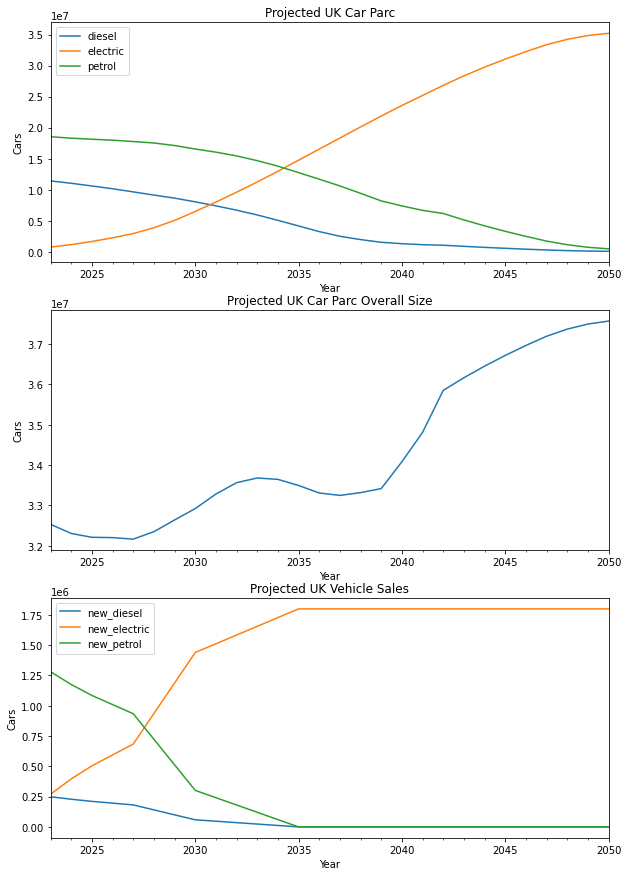

In [487]:
fig, [ax, ax2, ax3] = plt.subplots(3, 1, figsize=(10, 15))

dfp[['diesel', 'electric', 'petrol']].plot(ax=ax)

ax.set_title('Projected UK Car Parc')
ax.set_ylabel('Cars')
ax.set_xlabel('Year')

dfp.sum(axis=1).plot(ax=ax2)

ax2.set_title('Projected UK Car Parc Overall Size')
ax2.set_ylabel('Cars')
ax2.set_xlabel('Year')

dfp[['new_diesel', 'new_electric', 'new_petrol']].plot(ax=ax3)

ax3.set_title('Projected UK Vehicle Sales')
ax3.set_ylabel('Cars')
ax3.set_xlabel('Year')

plt.show()

Now we enter our mileage assumptions. 

In [488]:
dfp['diesel_miles'] = diesel_mileage #* .85
dfp['petrol_miles'] = petrol_mileage #* .85
dfp['electric_miles'] = electric_mileage #* .9

Now calculate vmt for each fueltype as product of annual mileage and parc. 

In [489]:
dfp['diesel_vmt'] = dfp.apply(lambda row: row.diesel_miles * row.diesel, axis=1)
dfp['petrol_vmt'] = dfp.apply(lambda row: row.petrol_miles * row.petrol, axis=1)
dfp['electric_vmt'] = dfp.apply(lambda row: row.electric_miles * row.electric, axis=1)

Now we enter in our MPG assumptions

In [490]:
dfp['diesel_economy'] = diesel_mpg
dfp['petrol_economy'] = petrol_mpg

Now calculate total gallons of petrol and diesel consumed.

In [491]:
dfp['car_petrol_consumption_gallons'] = dfp.apply(lambda row: row.petrol_vmt / row.petrol_economy, axis=1)
dfp['car_diesel_consumption_gallons'] = dfp.apply(lambda row: row.diesel_vmt/ row.diesel_economy, axis=1)

In [493]:
dfp['petrol_consumption'] = dfp.car_petrol_consumption_gallons.apply(lambda x: ((x/219.969)*.98)/1000)
dfp['diesel_consumption'] = dfp.car_diesel_consumption_gallons.apply(lambda x: ((x/219.969)*.86)/1000)

Now calculate emissions from each kind of fuel. 

In [494]:
dfp['diesel_emissions'] = dfp.diesel_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.23686)
dfp['petrol_emissions'] = dfp.petrol_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.22980)

In [495]:
df.iloc[-2:, 8:]

,petrol_mileage,electric_mileage,diesel_vmt,petrol_vmt,electric_vmt,hybrid_vmt,car_diesel_consumption,car_petrol_consumption,pure_petrol_share,hybrid_petrol_share,...,hybrid_economy,diesel_emissions,petrol_emissions,total_kgCO2e_calc,1A3bi_Cars_x,error,pure_petrol_economy,car_petrol_consumption_gallons,1A3bi_Cars_y,1A3bi_Cars
variable,,,,,,,,,,,,,,,,,,,,,
2021-12-31,5072.091349,8039.995988,8.563183e+10,9.496577e+10,3.087978e+09,2.595570e+09,NaN,NaN,0.981227,0.018773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.680257e+09,NaN,NaN
2022-12-31,5705.614549,9033.500161,9.597255e+10,1.073466e+11,4.481357e+09,3.358613e+09,NaN,NaN,0.978568,0.021432,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.029687e+09,NaN,NaN


In [500]:
# Let's fill in the gaps with an estimate for 2021 and 2022

df_sel = df.iloc[-2:]

df_sel['diesel_economy'] = diesel_mpg
df_sel['petrol_economy'] = petrol_mpg_start

df_sel['car_petrol_consumption_gallons'] = df_sel.apply(lambda row: row.petrol_vmt / row.petrol_economy, axis=1)
df_sel['car_diesel_consumption_gallons'] = df_sel.apply(lambda row: row.diesel_vmt/ row.diesel_economy, axis=1)

df_sel['petrol_consumption'] = df_sel.car_petrol_consumption_gallons.apply(lambda x: ((x/219.969)*.98)/1000)
df_sel['diesel_consumption'] = df_sel.car_diesel_consumption_gallons.apply(lambda x: ((x/219.969)*.86)/1000)

df_sel['diesel_emissions'] = df_sel.diesel_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.23686)
df_sel['petrol_emissions'] = df_sel.petrol_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.22980)

/Users/ben/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ben/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ben/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [501]:
historical = pd.concat([df_sel, df])
forecast = dfp.copy()

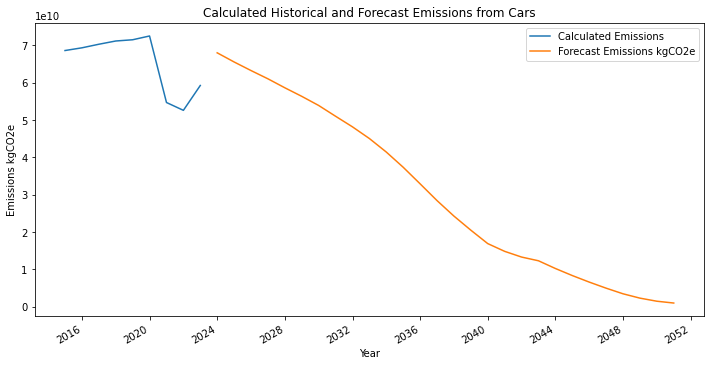

In [502]:
fig, ax=plt.subplots(figsize=(12, 6))

pd.concat([df[['diesel_emissions', 'petrol_emissions']].dropna(),
df_sel[['diesel_emissions', 'petrol_emissions']]]).sum(axis=1).plot(ax=ax, label='Calculated Emissions')
dfp[['diesel_emissions', 'petrol_emissions']].sum(axis=1).plot(ax=ax, label='Forecast Emissions kgCO2e')

ax.legend()
ax.set_ylabel('Emissions kgCO2e')
ax.set_xlabel('Year')
ax.set_title('Calculated Historical and Forecast Emissions from Cars')
# ax.set_ylim(0, 4300000000)

# plt.savefig('plots/emissions.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')


plt.show()

<AxesSubplot:>

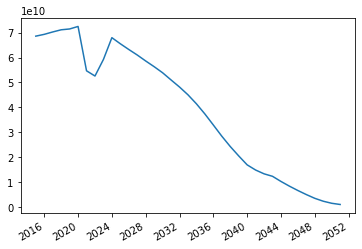

In [503]:
pd.concat([df[['diesel_emissions', 'petrol_emissions']].dropna(),
df_sel[['diesel_emissions', 'petrol_emissions']],
dfp[['diesel_emissions', 'petrol_emissions']]]).sum(axis=1).plot()

(0.0, 300000000000.0)

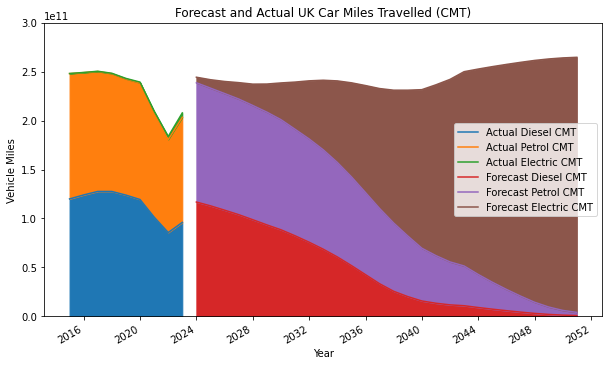

In [504]:
fig, ax = plt.subplots(figsize=(10, 6))

historical[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].dropna().plot(kind='area', ax=ax)

forecast[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].dropna().plot(kind='area', ax=ax)

ax.legend(['Actual Diesel CMT', 'Actual Petrol CMT', 'Actual Electric CMT', 'Forecast Diesel CMT', 'Forecast Petrol CMT', 'Forecast Electric CMT'])

ax.set_title('Forecast and Actual UK Car Miles Travelled (CMT)')

ax.set_ylabel('Vehicle Miles')
ax.set_xlabel('Year')

ax.set_ylim(0, 300000000000)

# plt.savefig('plots/uk_vehicle_miles_past_future.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')


Text(0.5, 0, 'Year')

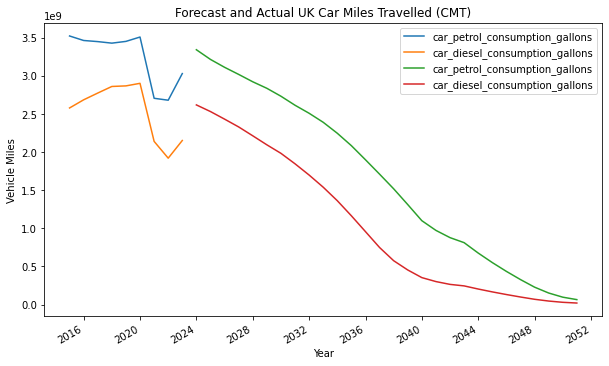

In [506]:
fig, ax = plt.subplots(figsize=(10, 6))

historical[['car_petrol_consumption_gallons', 'car_diesel_consumption_gallons']].dropna().plot( ax=ax)
forecast[['car_petrol_consumption_gallons', 'car_diesel_consumption_gallons']].dropna().plot( ax=ax)

# forecast[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].dropna().plot(ax=ax)

# ax.legend(['Actual Diesel CMT', 'Actual Petrol CMT', 'Actual Electric CMT', 'Forecast Diesel CMT', 'Forecast Petrol CMT', 'Forecast Electric CMT'])

ax.set_title('Forecast and Actual UK Car Miles Travelled (CMT)')

ax.set_ylabel('Vehicle Miles')
ax.set_xlabel('Year')

# ax.set_ylim(0, 300000000000)

# plt.savefig('plots/uk_vehicle_miles_past_future.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')

Text(0.5, 0, 'Year')

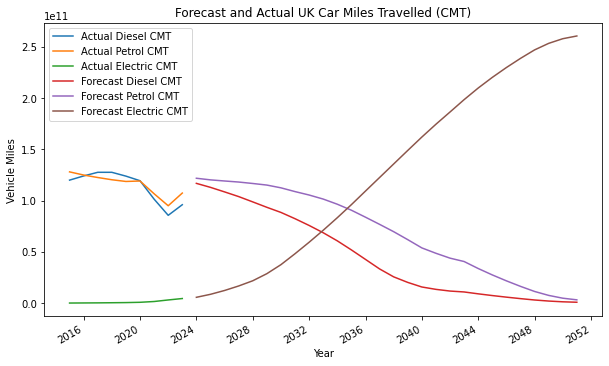

In [515]:
fig, ax = plt.subplots(figsize=(10, 6))

historical[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].dropna().plot( ax=ax)

forecast[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].dropna().plot(ax=ax)

ax.legend(['Actual Diesel CMT', 'Actual Petrol CMT', 'Actual Electric CMT', 'Forecast Diesel CMT', 'Forecast Petrol CMT', 'Forecast Electric CMT'])

ax.set_title('Forecast and Actual UK Car Miles Travelled (CMT)')

ax.set_ylabel('Vehicle Miles')
ax.set_xlabel('Year')

# ax.set_ylim(0, 300000000000)

# plt.savefig('plots/uk_vehicle_miles_past_future.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')


Text(0.5, 0, 'Year')

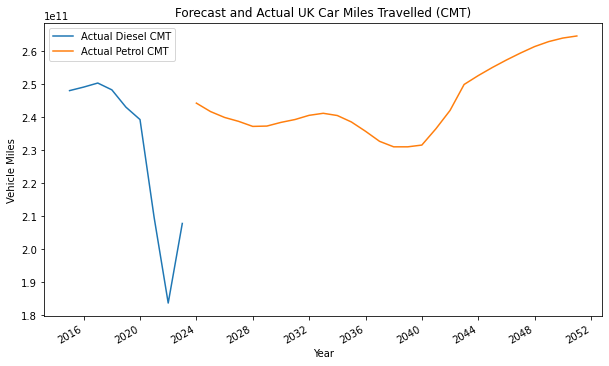

In [513]:
fig, ax = plt.subplots(figsize=(10, 6))

historical[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].sum(axis=1).dropna().plot( ax=ax)

forecast[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].sum(axis=1).dropna().plot(ax=ax)

ax.legend(['Actual Diesel CMT', 'Actual Petrol CMT', 'Actual Electric CMT', 'Forecast Diesel CMT', 'Forecast Petrol CMT', 'Forecast Electric CMT'])

ax.set_title('Forecast and Actual UK Car Miles Travelled (CMT)')

ax.set_ylabel('Vehicle Miles')
ax.set_xlabel('Year')

# ax.set_ylim(0, 300000000000)

# plt.savefig('plots/uk_vehicle_miles_past_future.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')

Text(0.5, 0, 'Year')

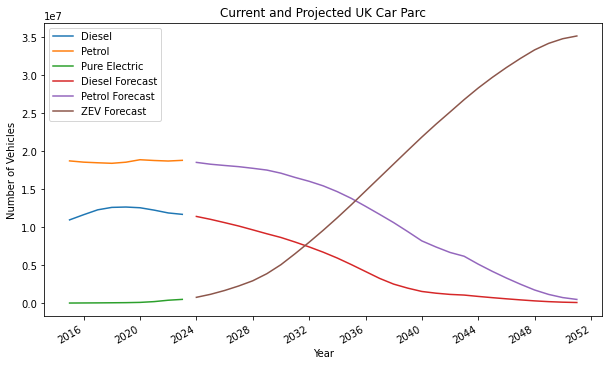

In [514]:
fig, ax = plt.subplots(figsize=(10, 6))

historical[['Diesel', 'Petrol', 'Pure Electric']].plot(ax=ax)
forecast[['diesel', 'petrol', 'electric']].rename(columns={'diesel':'Diesel Forecast', 'petrol':'Petrol Forecast', 'electric':'ZEV Forecast'}).plot(ax=ax)

ax.set_title('Current and Projected UK Car Parc')
# ax.legend(['Diesel', 'Petrol', 'ZEV', 'Diesel Forecast', 'Petrol Forecast', 'ZEV Forecast'])

ax.set_ylabel('Number of Vehicles')
ax.set_xlabel('Year')

# plt.savefig('plots/vehicle_parc_past_future.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')


In [525]:
end_emissions

971723407.1390429

In [534]:
start_emissions = historical[['petrol_emissions', 'diesel_emissions']].sum(axis=1).iloc[-1]
end_emissions = forecast[['petrol_emissions', 'diesel_emissions']].sum(axis=1).iloc[-1]

print("Total emissions saved: {}".format(start_emissions - end_emissions))
print("Emissions elimited by 2050: {}%".format(round(100*(start_emissions - end_emissions) / start_emissions, ndigits=2)))

Total emissions saved: 58275299896.7731
Emissions elimited by 2050: 98.36%


In [530]:
round(100*(start_emissions - end_emissions) / start_emissions, ndigits=2)

98.36